<a href="https://colab.research.google.com/github/Xianhui-He/Raclette-Group-2-ECoG-Motor-Imagery/blob/main/Motor_Imagery_Dataset_Data_Wrangling_Preprocessing_Hanif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [254]:
# Boring Stuffs, JK It's Important, Download Dataset

import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [255]:
# Install Non-Built-In Packages

!pip install mne --quiet

In [256]:
# Import Stuffs (Packages)

import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

import mne
from mne import create_info, EpochsArray
from mne.io import RawArray
from mne.baseline import rescale
from mne.time_frequency import (tfr_multitaper, tfr_stockwell, tfr_morlet, tfr_array_morlet)
from mne.viz import centers_to_edges

from matplotlib import rcParams
from matplotlib import pyplot as plt

In [270]:
# Misc Codes For Figure

rcParams['font.size'] = 10

In [258]:
# Load Dataset

alldat = np.load(fname, allow_pickle=True)['dat']

In [269]:
# Get ROI Electrodes (Post Central & Precentral Gyrus)

electrode_roi = []

# Iterate for Each Subject
for subject_index, subject in enumerate(alldat):

  electrode_indexes_precentral = []
  electrode_indexes_postcentral = []

  for gyrus_index, gyrus in enumerate(subject[0]['gyrus']):
    if gyrus == 'Precentral Gyrus':
      electrode_indexes_precentral.append(gyrus_index)
    elif gyrus == 'Postcentral Gyrus':
      electrode_indexes_postcentral.append(gyrus_index)

  electrode_roi.append(electrode_indexes_precentral + electrode_indexes_postcentral)

  print('\033[1m' + 'Subject {}:'.format(subject_index) + '\033[0m' + """\n  Precentral Gyrus: {}\n  Postcentral Gyrus: {}""".format(electrode_indexes_precentral,electrode_indexes_postcentral))

Subject 0:
  Precentral Gyrus: [5, 6, 7, 12, 20, 27, 28, 35, 36, 41, 42]
  Postcentral Gyrus: [13, 14, 21, 29, 37, 43, 44]
Subject 1:
  Precentral Gyrus: [7, 14, 15, 21, 22, 29, 30, 31, 37]
  Postcentral Gyrus: [23, 38, 39, 47]
Subject 2:
  Precentral Gyrus: [25, 26, 35, 36, 43, 44, 45]
  Postcentral Gyrus: [27, 28, 29, 37, 46]
Subject 3:
  Precentral Gyrus: [4, 5, 11, 12, 19, 20, 28, 35, 36, 42, 43]
  Postcentral Gyrus: [3, 18, 26, 27, 34, 41]
Subject 4:
  Precentral Gyrus: [7, 14, 21, 22, 23, 28, 29]
  Postcentral Gyrus: [15, 30, 31]
Subject 5:
  Precentral Gyrus: [0, 1, 8, 9, 10, 18, 26, 27, 34, 35, 43, 44, 52, 53]
  Postcentral Gyrus: [16, 17, 24, 25, 33, 42, 50, 51]
Subject 6:
  Precentral Gyrus: [34, 42, 43, 44, 51, 52, 60]
  Postcentral Gyrus: [27, 28, 35, 36, 45, 53, 61, 62, 63]


In [313]:
# Get ROI Electrodes (According to Literature, Only for Subject 0)

electrode_roi_lit = [10, 11, 18, 19, 20, 25, 26, 27]

print('\033[1m' + 'Subject 0:'.format(subject_index) + '\033[0m' + """\n {}""".format(electrode_roi_lit))

Subject 0:
 [10, 11, 18, 19, 20, 25, 26, 27]


In [309]:
# Data Prep Stuffs

# TODO: Data Preprocessing Needs to Be Refined

# Number of Subjects
subject_count = alldat.shape[0]

# Instantiate Empty Array for All Subjects's Tongue & Hand Epochs
tongue_epochs_real = []
tongue_epochs_imagery = [] 
hand_epochs_real = []
hand_epochs_imagery = []

# Iterate for Each Subject
for subject in alldat:

  # Iterate for Each Test Block (Real & Imagery)
  for index, block in enumerate(subject):

    # Get Timepoints Count, Channel Counts, Sampling Rate & (Total) Stimulus Counts
    time_samples, channels = block['V'].shape
    sampling_freq = block['srate']
    n_stimulus = len(block['t_on'])

    # Generate MNE Info Object Based on Previous Code (Unused for Now)
    block_info = create_info(ch_names=channels, sfreq=sampling_freq, ch_types='ecog')

    # Extract Continuous Voltage Data & Assign Proper Type
    volt_data = block['V'].astype('float32')

    # Multiply with Scale to Calculate uV Values (Unused for Now)
    #volt_data = volt_data * block['scale_uv']

    ### Filtering Stuffs HERE ###

    # 3rd Order Butterworth Filter (High-pass 5Hz)
    b, a = signal.butter(3, [5], btype='high', fs=1000)
    volt_data = signal.filtfilt(b, a, volt_data, 0)

    # 3rd Order Butterworth Filter (Low-pass 200Hz)
    b, a = signal.butter(3, [150], btype='low', fs=1000)
    volt_data = signal.filtfilt(b, a, volt_data, 0)

    ### END of Filtering Stuffs ###

    # Normalize Voltage Data (Unused for Now)
    #volt_data = volt_data/volt_data.mean(0)

    # Extract {window} ms after Stimulus Onset for All Stimulus (~60 Total), Creating Epochs-Array
    window = 2048
    epoch_window = np.arange(0, window)
    shifted_t_on = block['t_on']-100  # Get -100ms before stimulus onset
    epoch_timepoints = shifted_t_on[:, np.newaxis] + epoch_window

    # Transpose Data to Match NME Epochs Object Input Dimension (Credits to Xianhui)
    V_epochs_combined = volt_data[epoch_timepoints, :].transpose((0,2,1))

    # Separate Epochs Between Tongue & Hand
    V_epochs_tongue = (V_epochs_combined[block['stim_id'] == 11, :, :])
    V_epochs_hand = (V_epochs_combined[block['stim_id'] == 12, :, :])

    # Generate MNE Epochs Object & Append to All Subjects Tongue & Hand Epochs Array
    if index == 0:
      tongue_epochs_real.append(mne.EpochsArray(data=V_epochs_tongue, info=block_info, verbose='WARNING', tmin=-0.1))
      hand_epochs_real.append(mne.EpochsArray(data=V_epochs_hand, info=block_info, verbose='WARNING', tmin=-0.1))
    else:
      tongue_epochs_imagery.append(mne.EpochsArray(data=V_epochs_tongue, info=block_info, verbose='WARNING', tmin=-0.1))
      hand_epochs_imagery.append(mne.EpochsArray(data=V_epochs_hand, info=block_info, verbose='WARNING', tmin=-0.1))

# Show Resulting Epochs Object Info

tongue_epochs_real[0]

Number of events,30
Events,1: 30
Time range,-0.100 – 1.947 sec
Baseline,off


Tongue Real Movement Epochs-Averaged ERP - Subject 1


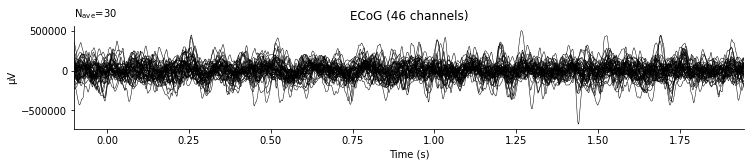

Hand Real Movement Epochs-Averaged ERP - Subject 1


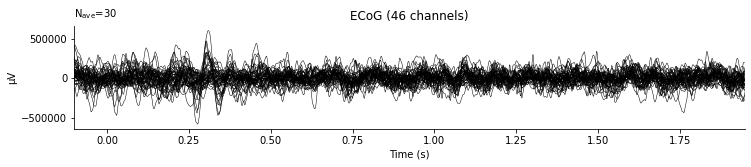

Tongue Imagery Movement Epochs-Averaged ERP - Subject 1


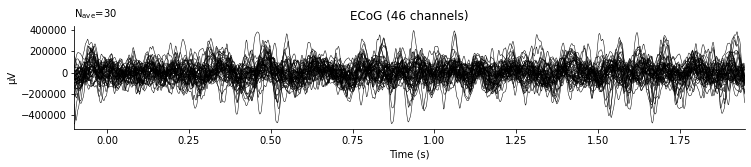

Hand Imagery Movement Epochs-Averaged ERP - Subject 1


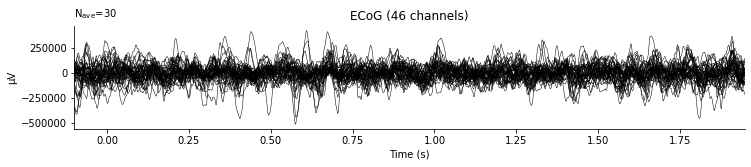

In [302]:
# Plot Epochs-Averaged ERP

tongue_real = tongue_epochs_real[0].average()
hand_real  = hand_epochs_real[0].average()
tongue_imagery = tongue_epochs_imagery[0].average()
hand_imagery  = hand_epochs_imagery[0].average()


ax = plt.subplot(2, 2, 1)
print("Tongue Real Movement Epochs-Averaged ERP - Subject 1")
tongue_real.plot(axes=ax);

ax = plt.subplot(2, 2, 2)
print("Hand Real Movement Epochs-Averaged ERP - Subject 1")
hand_real.plot(axes=ax);

ax = plt.subplot(2, 2, 3)
print("Tongue Imagery Movement Epochs-Averaged ERP - Subject 1")
tongue_imagery.plot(axes=ax);

ax = plt.subplot(2, 2, 4)
print("Hand Imagery Movement Epochs-Averaged ERP - Subject 1")
hand_imagery.plot(axes=ax);

Tongue - Real Movement:


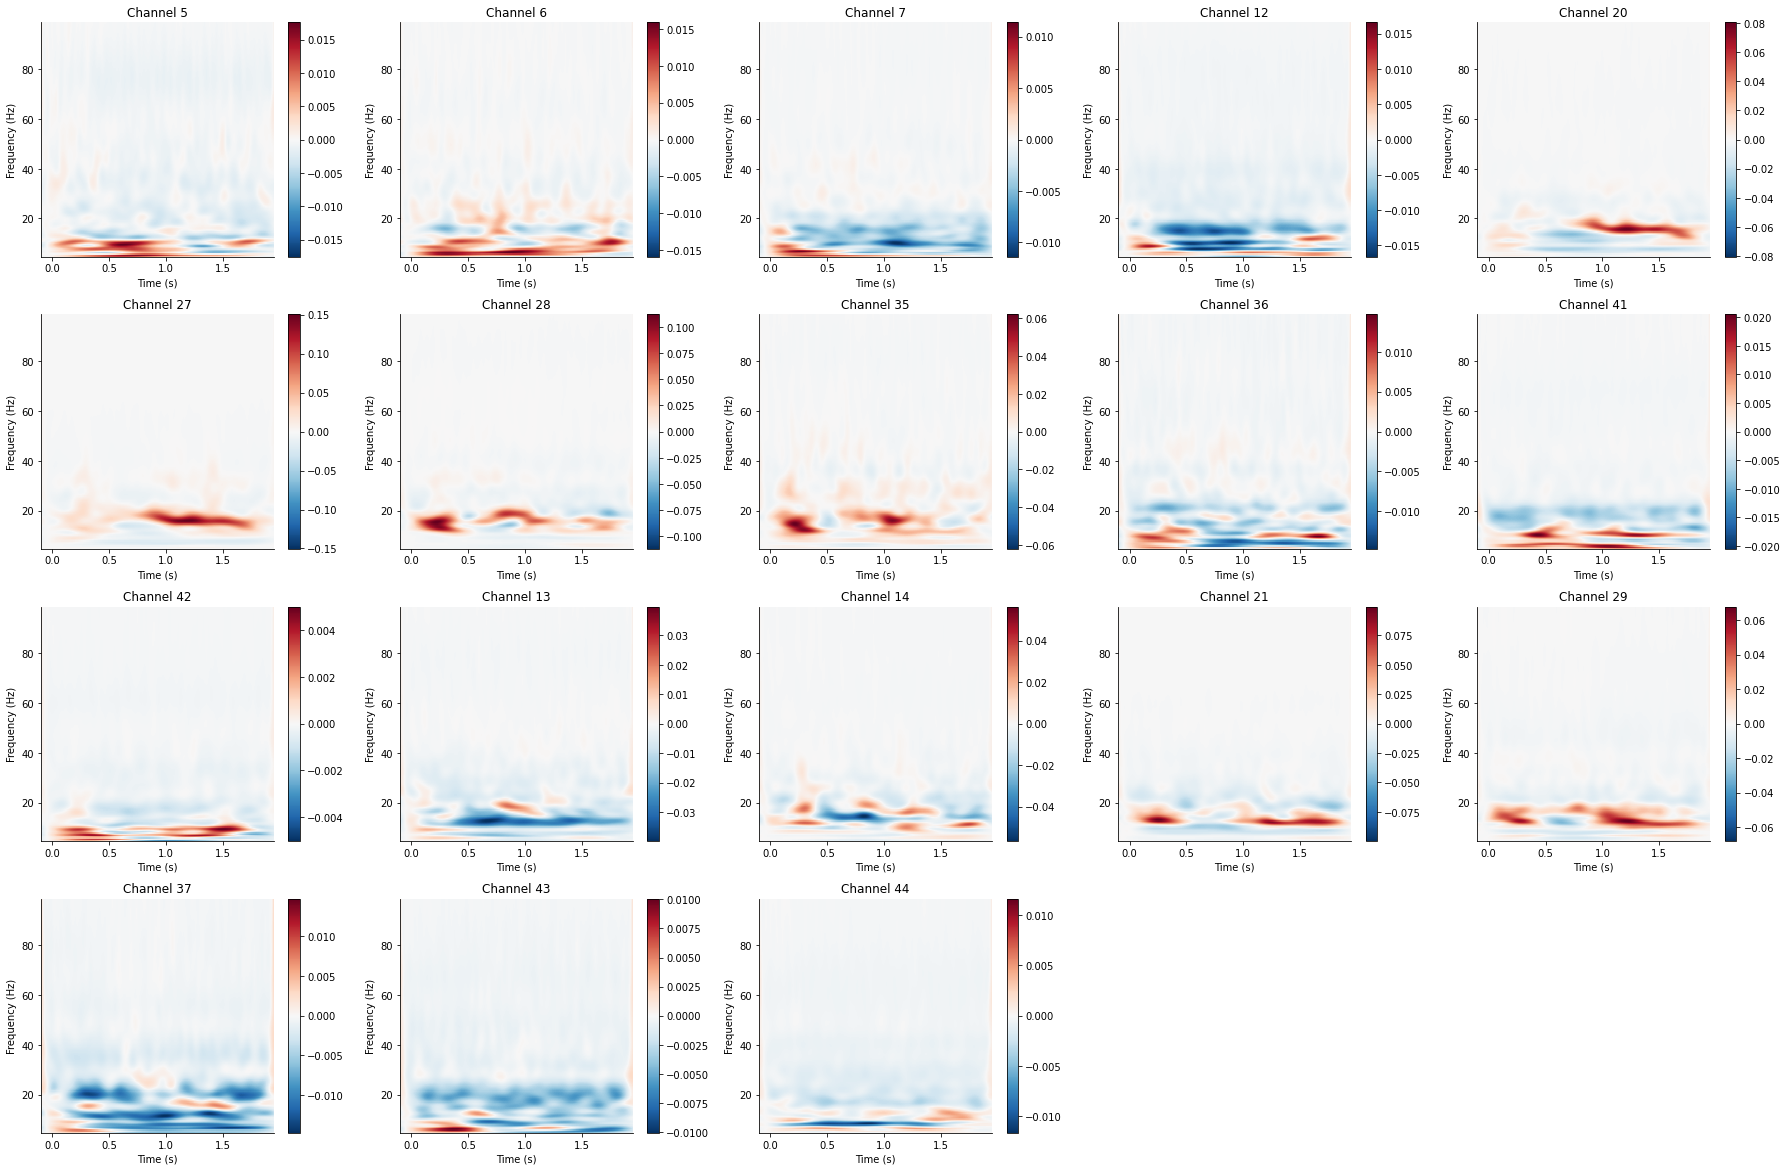

In [303]:
# Time-Frequency Decomposition Using Stockwell Transform (Tongue - Real Movement)

# ROI Channels
channels = electrode_roi[0]
n_channels = len(channels)

# TFA Parameters
freqs = np.arange(5., 100., 2.)
width = 0.7
fmin, fmax = freqs[[0, -1]]

# Decompose All Channels
power = tfr_stockwell(tongue_epochs_real[0], fmin=fmin, fmax=fmax, width=width)

# Plot Resulting Spectrogram of All Channels
print("Tongue - Real Movement:")
plt.figure(figsize=(25, 20))
for index, channel in enumerate(channels):
  ax = plt.subplot(5, 5, index+1)
  power.plot([index], mode='mean', axes=ax, show=False, baseline=(-0.1, 0.), colorbar=True, verbose='WARNING')
  ax.set_title('Channel {}'.format(channel))
plt.show()

Tongue - Imagery Movement:


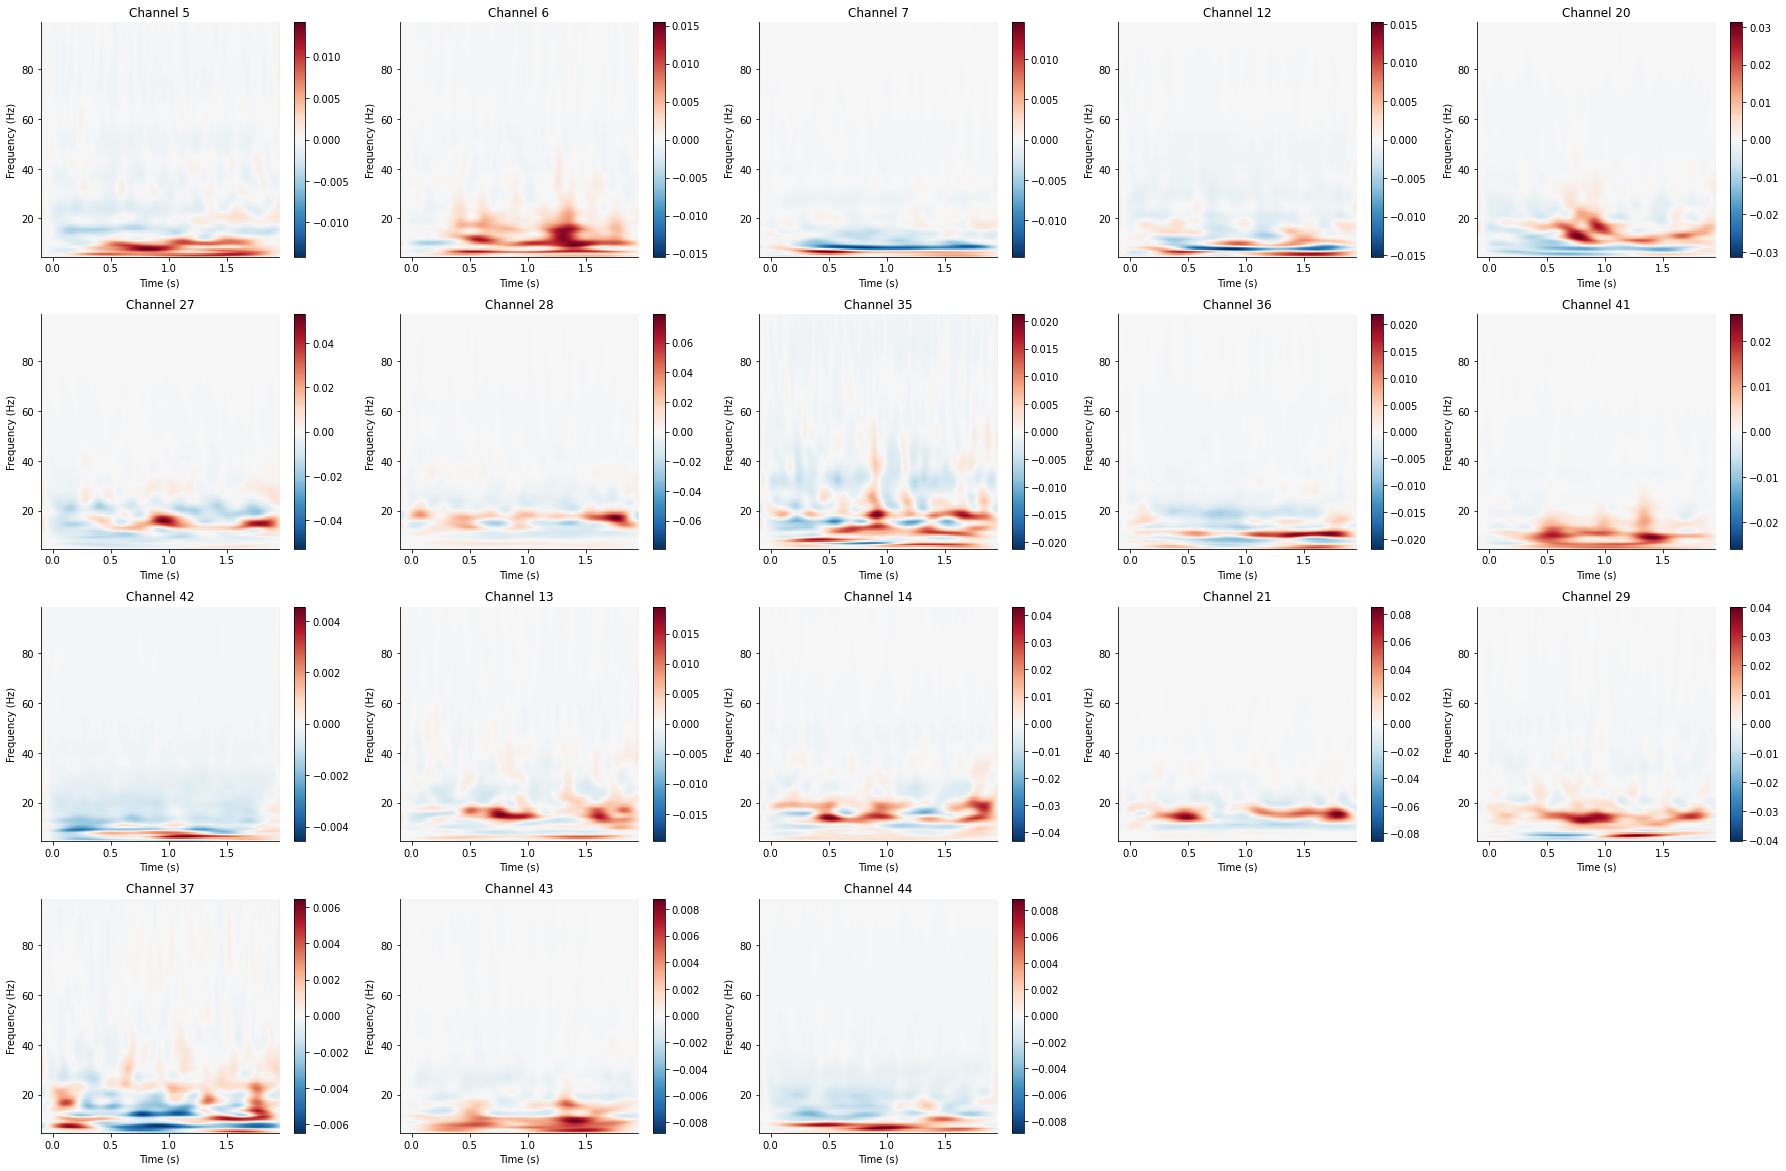

In [304]:
# Time-Frequency Decomposition Using Stockwell Transform (Tongue - Imagery Movement)

# ROI Channels
channels = electrode_roi[0]
n_channels = len(channels)

# TFA Parameters
freqs = np.arange(5., 100., 2.)
width = 0.7
fmin, fmax = freqs[[0, -1]]

# Decompose All Channels
power = tfr_stockwell(tongue_epochs_imagery[0], fmin=fmin, fmax=fmax, width=width)

# Plot Resulting Spectrogram of All Channels
print("Tongue - Imagery Movement:")
plt.figure(figsize=(25, 20))
for index, channel in enumerate(channels):
  ax = plt.subplot(5, 5, index+1)
  power.plot([index], mode='mean', axes=ax, show=False, baseline=(-0.1, 0.), colorbar=True, verbose='WARNING')
  ax.set_title('Channel {}'.format(channel))
plt.show()

Hand - Real Movement:


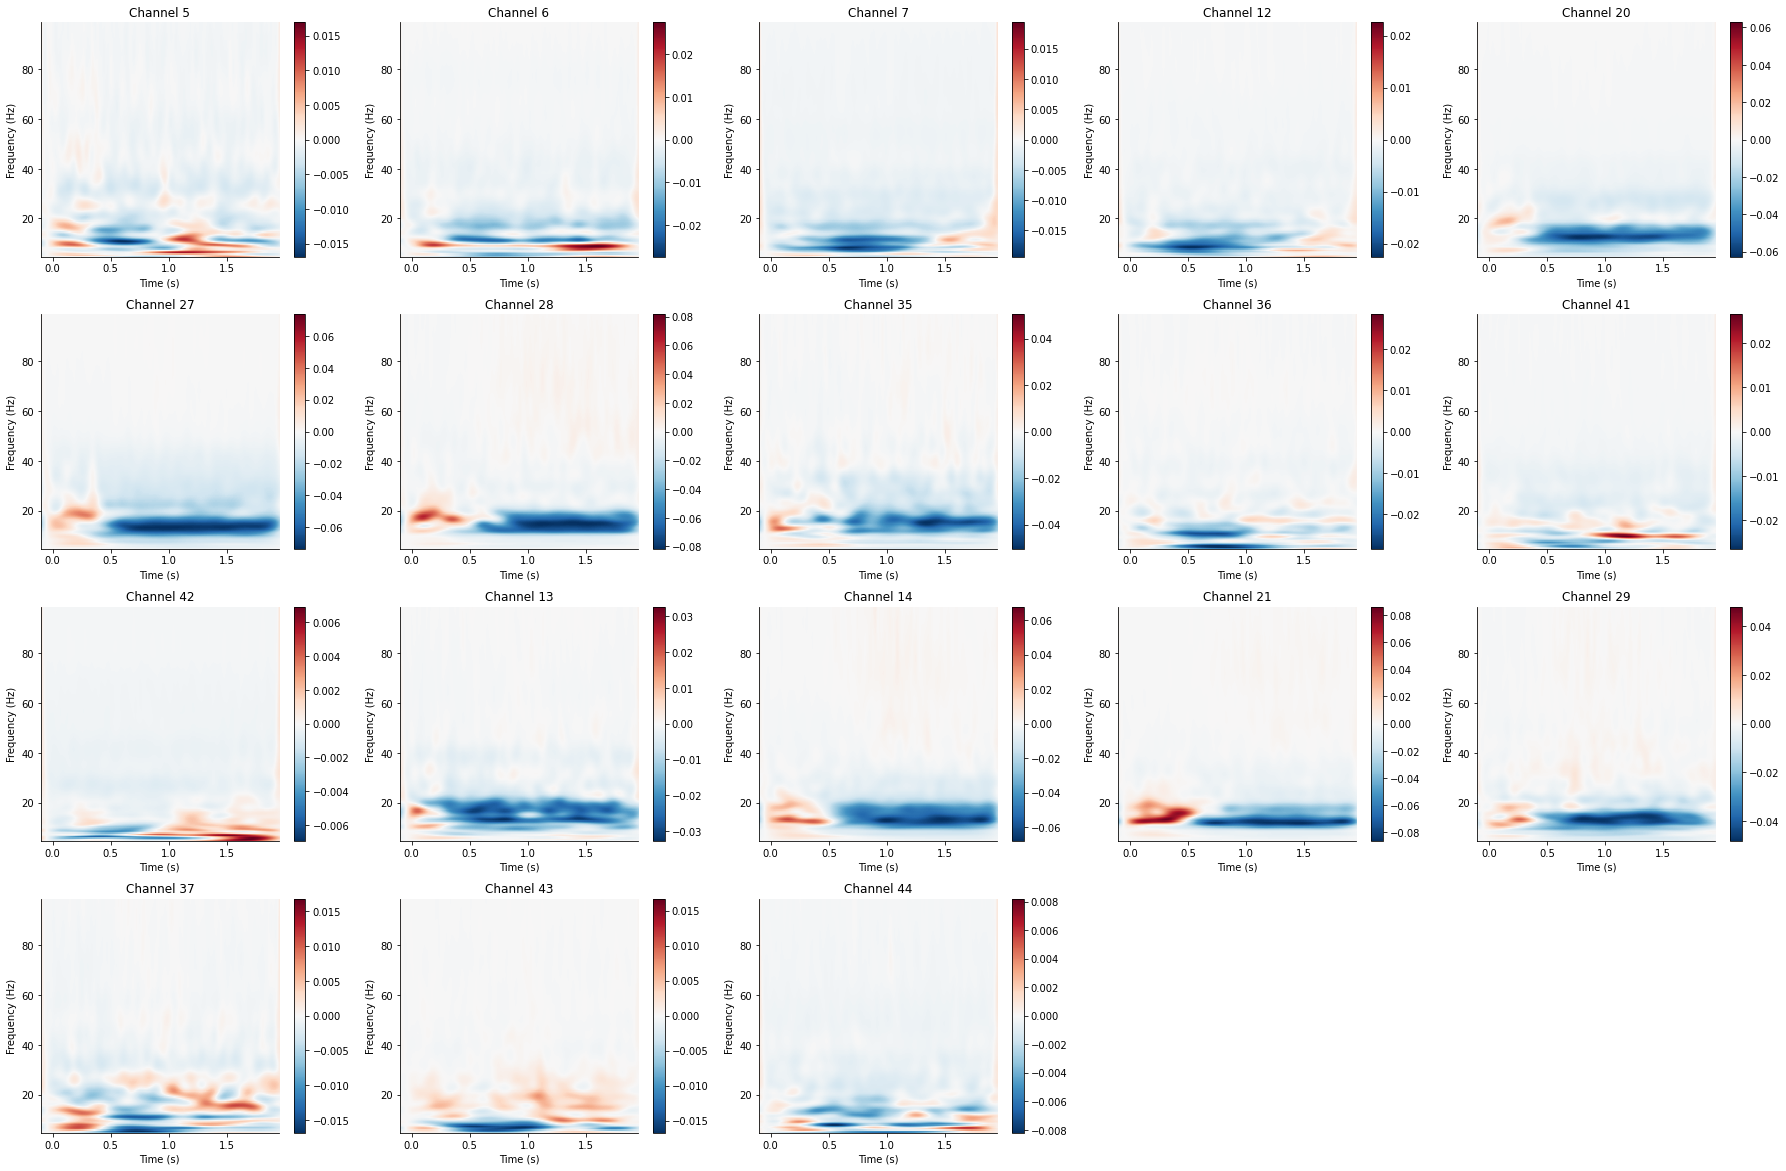

In [310]:
# Time-Frequency Decomposition Using Stockwell Transform (Hand - Real Movement)

# ROI Channels
channels = electrode_roi[0]
n_channels = len(channels)

# TFA Parameters
freqs = np.arange(5., 100., 2.)
width = 0.7
fmin, fmax = freqs[[0, -1]]

# Decompose All Channels
power = tfr_stockwell(hand_epochs_real[0], fmin=fmin, fmax=fmax, width=width)

# Plot Resulting Spectrogram of All Channels
print("Hand - Real Movement:")
plt.figure(figsize=(25, 20))
for index, channel in enumerate(channels):
  ax = plt.subplot(5, 5, index+1)
  power.plot([index], mode='mean', axes=ax, show=False, baseline=(-0.1, 0.), colorbar=True, verbose='WARNING')
  ax.set_title('Channel {}'.format(channel))
plt.show()

Hand - Imagery Movement:


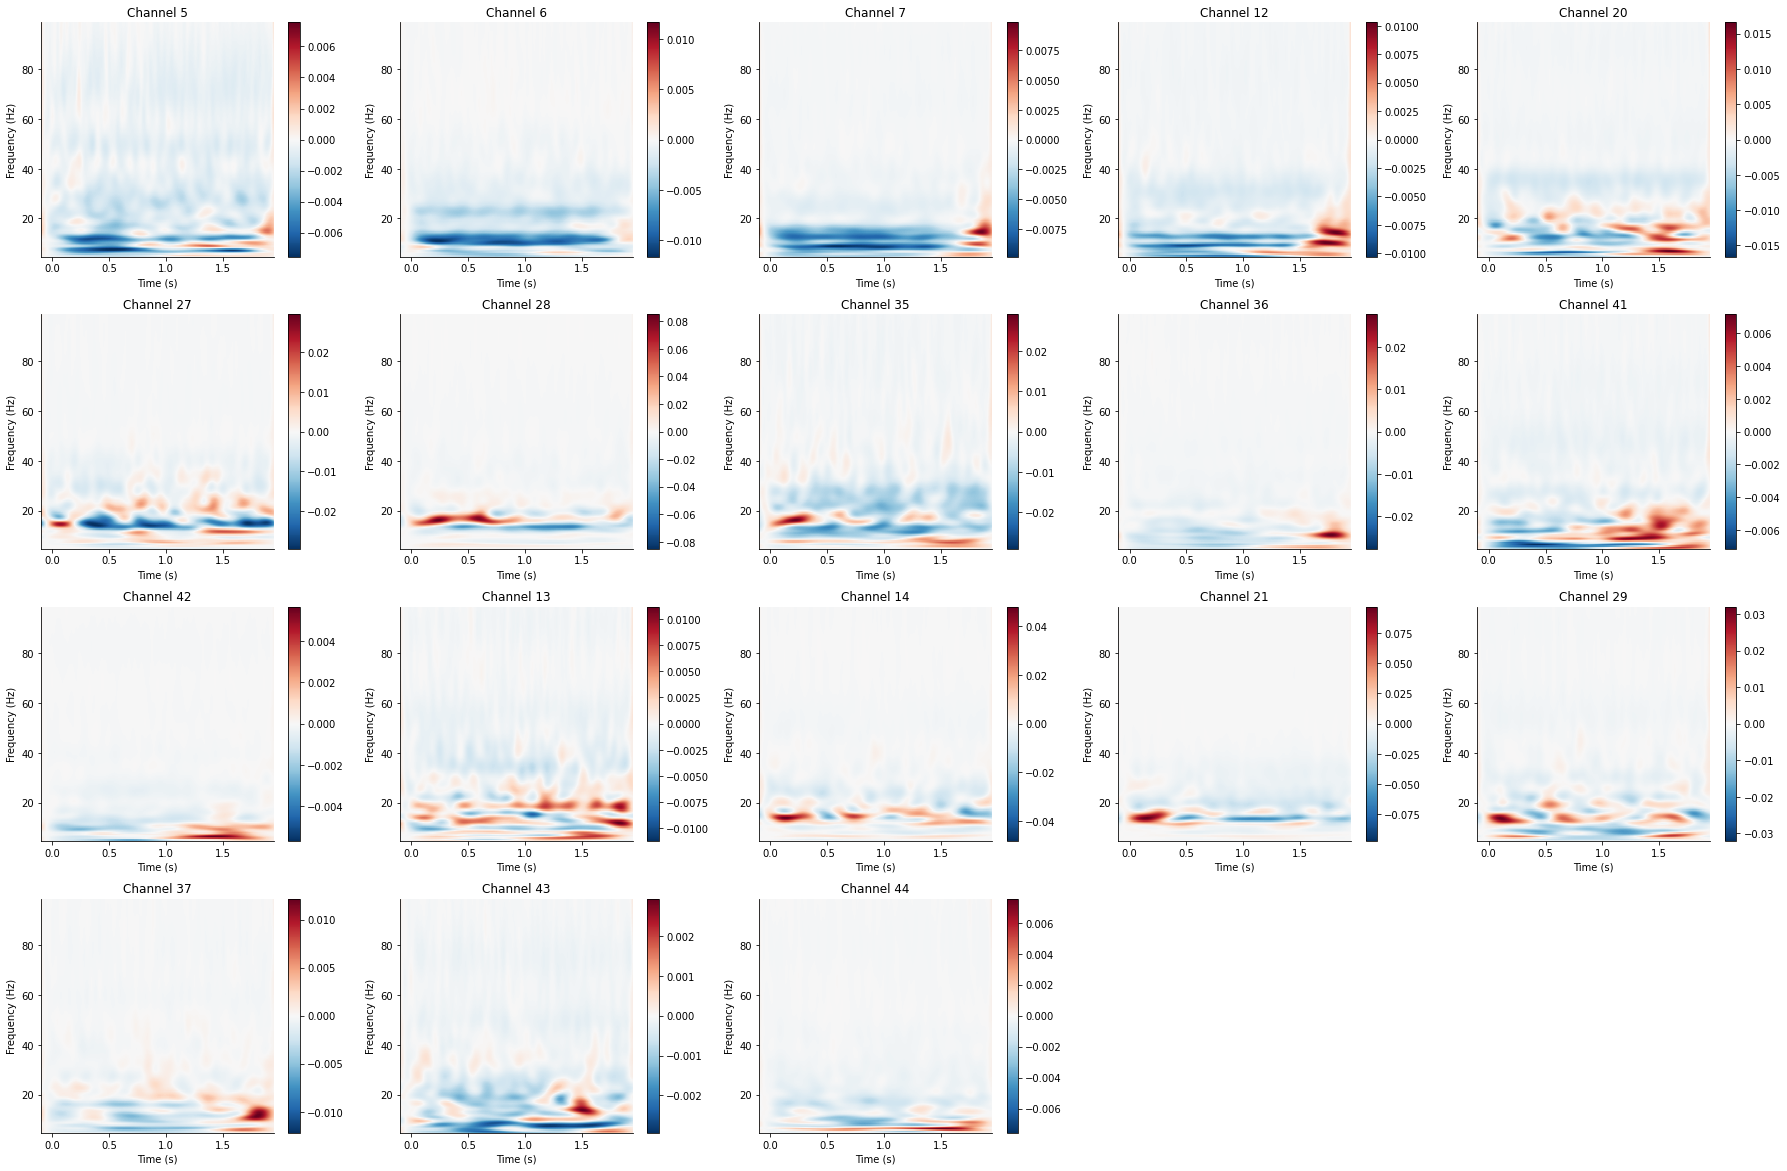

In [308]:
# Time-Frequency Decomposition Using Stockwell Transform (Hand - Imagery Movement)

# ROI Channels
channels = electrode_roi[0]
n_channels = len(channels)

# TFA Parameters
freqs = np.arange(5., 100., 2.)
width = 0.7
fmin, fmax = freqs[[0, -1]]

# Decompose All Channels
power = tfr_stockwell(hand_epochs_imagery[0], fmin=fmin, fmax=fmax, width=width)

# Plot Resulting Spectrogram of All Channels
print("Hand - Imagery Movement:")
plt.figure(figsize=(25, 20))
for index, channel in enumerate(channels):
  ax = plt.subplot(5, 5, index+1)
  power.plot([index], mode='mean', axes=ax, show=False, baseline=(-0.1, 0.), colorbar=True, verbose='WARNING')
  ax.set_title('Channel {}'.format(channel))
plt.show()

Tongue - Real Movement:


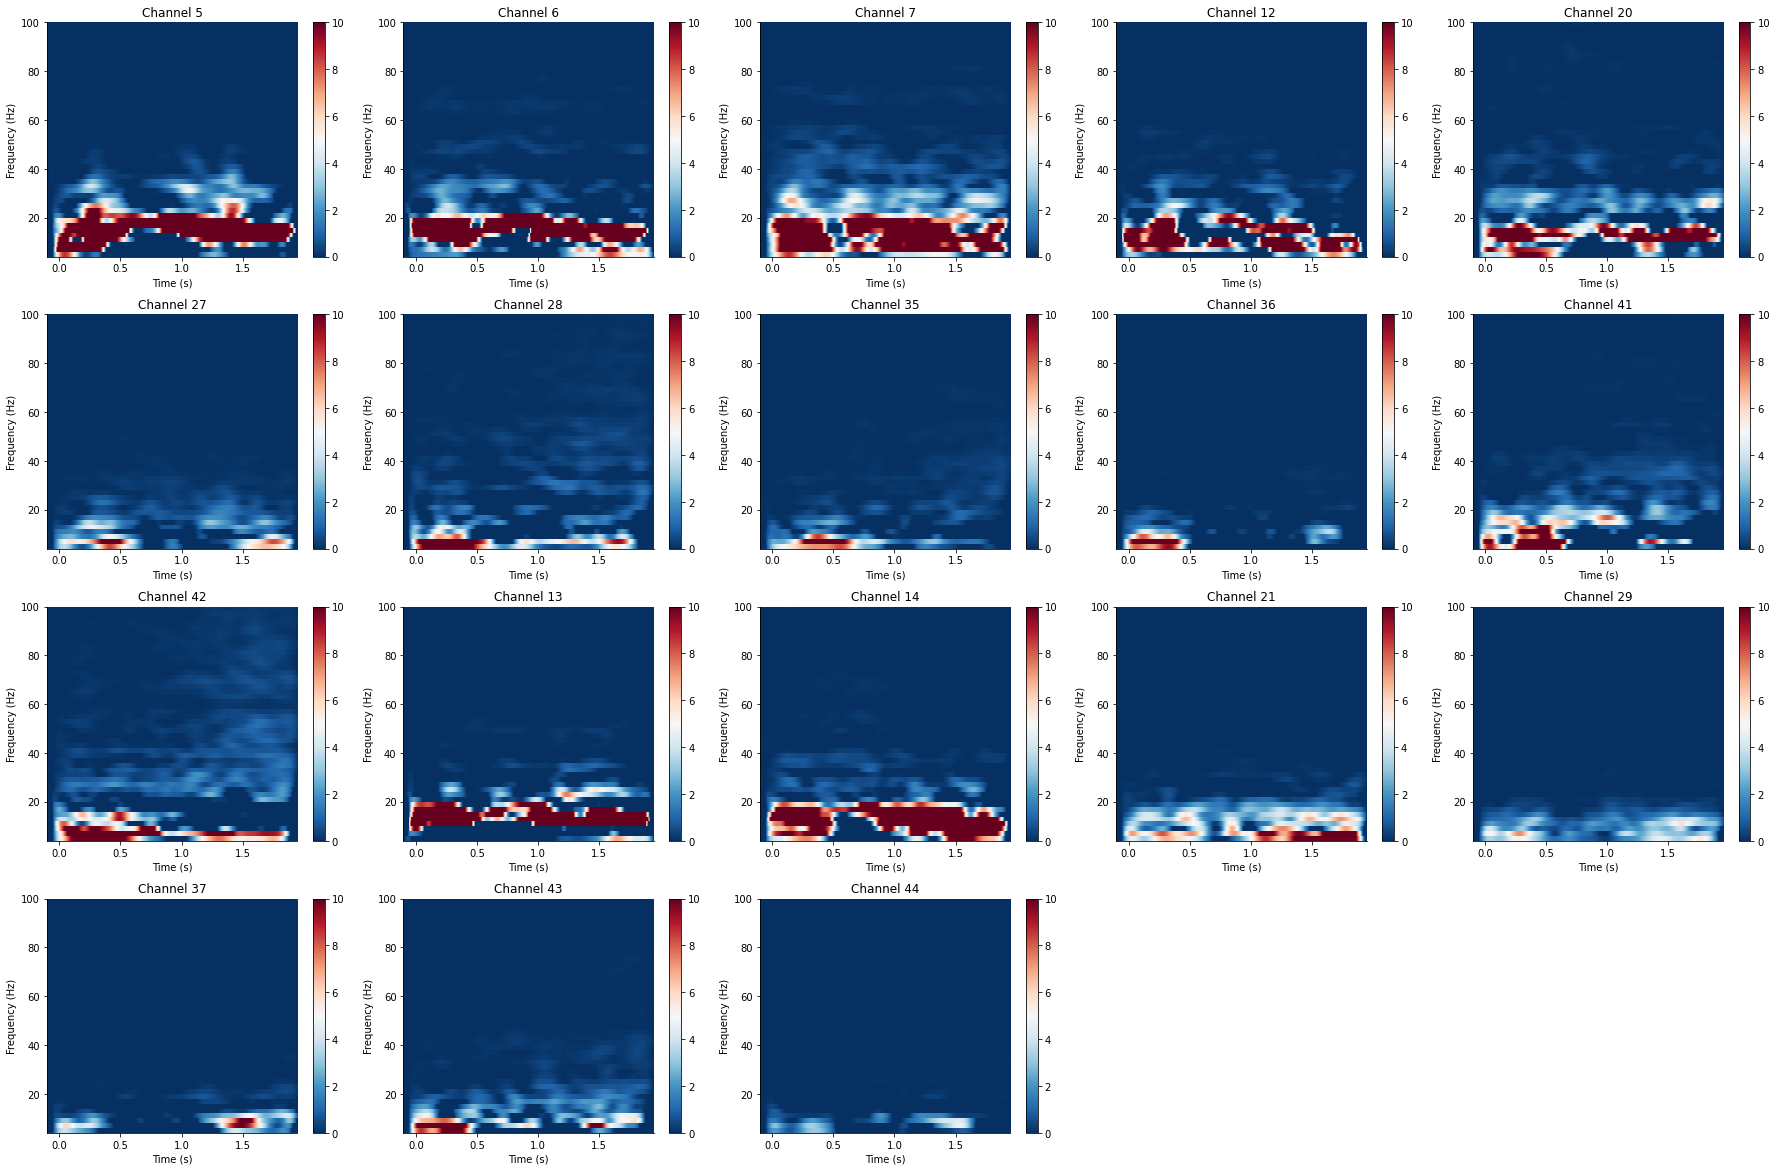

In [288]:
# Time-Frequency Decomposition Using Morlet Wavelet (Tongue - Real Movement)

# ROI Channels
channels = electrode_roi[0]
n_channels = len(channels)

# TFA Parameters
freqs = np.arange(5., 100., 2.)
n_cycles = freqs/2.
vmin, vmax = 0., 10. 

# Decompose All Channels
power = tfr_morlet(tongue_epochs_real[0], freqs=freqs, use_fft=True, n_cycles=n_cycles, return_itc=False, picks=channels)

# Plot Resulting Spectrogram of All Channels
print("Tongue - Real Movement:")
plt.figure(figsize=(25, 20))
for index, channel in enumerate(channels):
  ax = plt.subplot(5, 5, index+1)
  power.plot([index], mode='mean', vmin=vmin, vmax=vmax, baseline=(-0.1, 0.), axes=ax, show=False, colorbar=True, verbose='WARNING')
  ax.set_title('Channel {}'.format(channel))
plt.show()

Tongue - Real Movement:


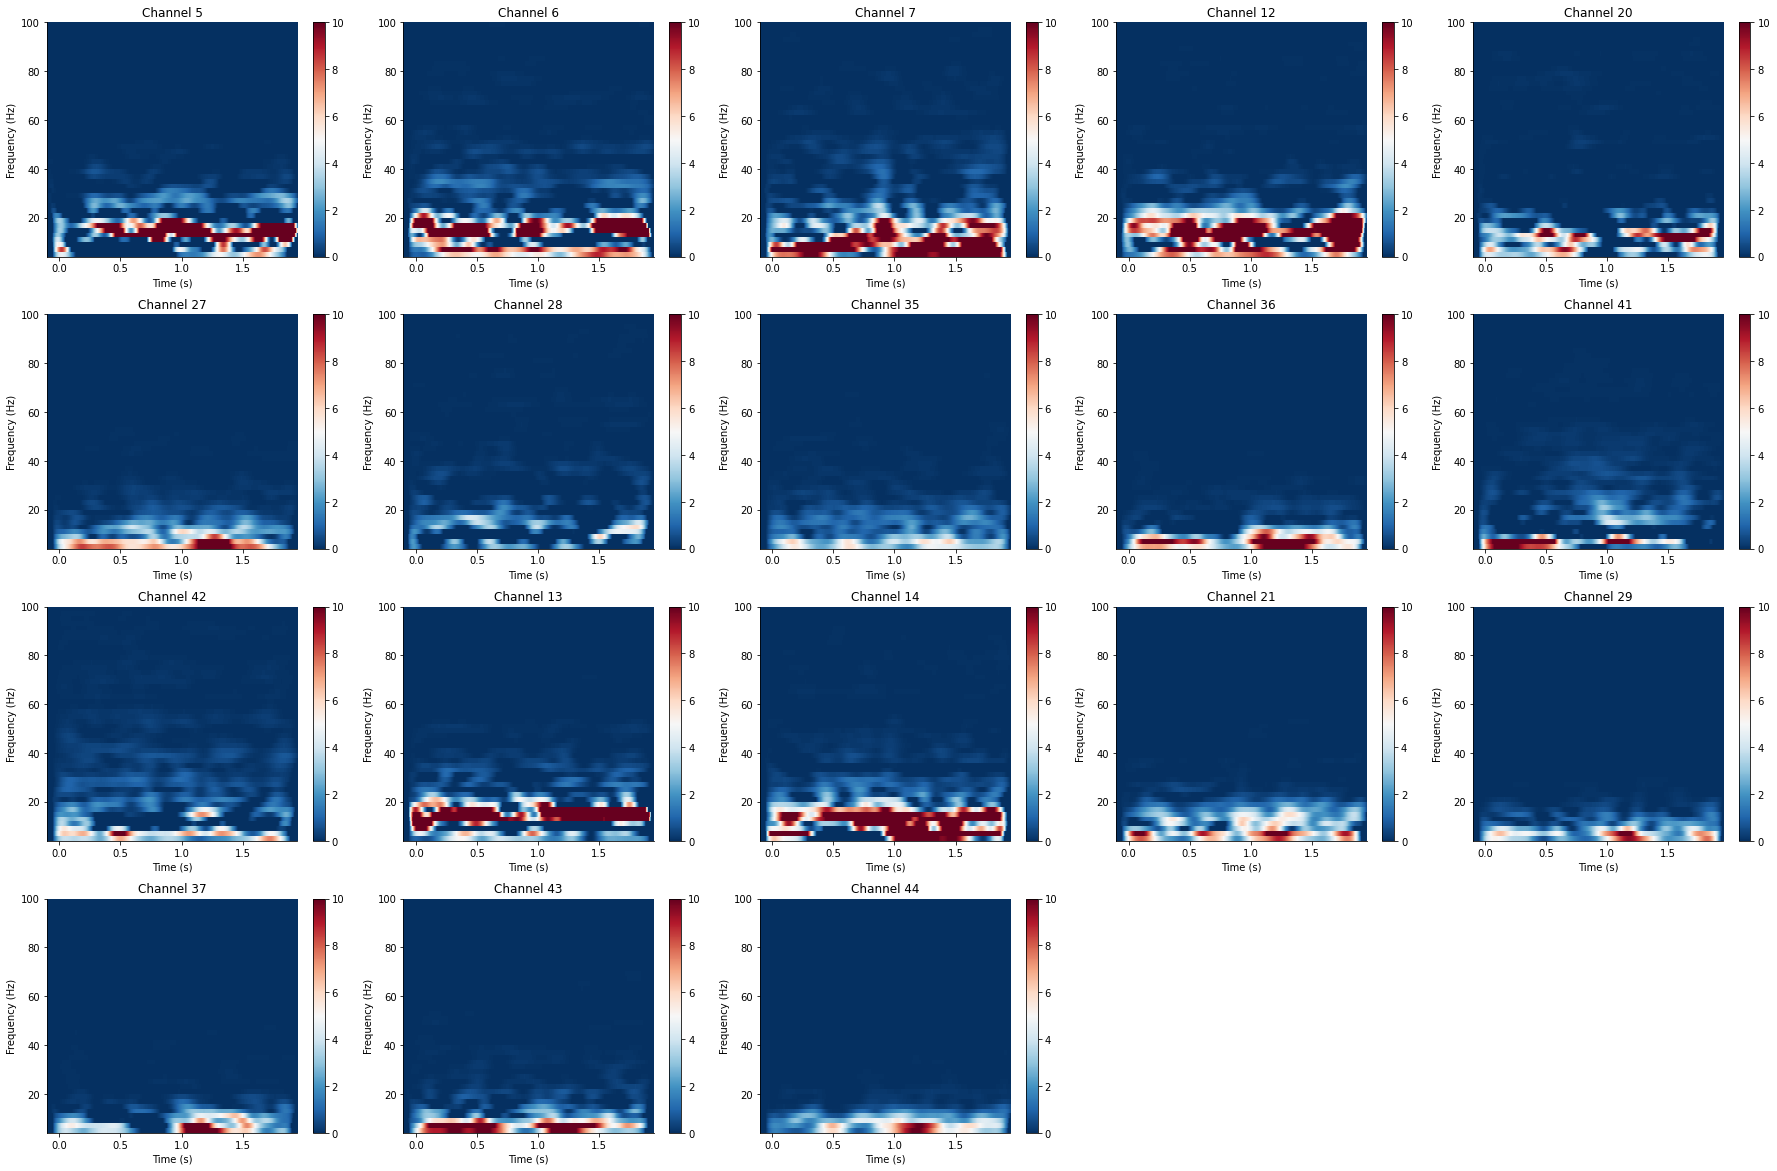

In [290]:
# Time-Frequency Decomposition Using Morlet Wavelet (Tongue - Imagery Movement)

# ROI Channels
channels = electrode_roi[0]
n_channels = len(channels)

# TFA Parameters
freqs = np.arange(5., 100., 2.)
n_cycles = freqs/2.
vmin, vmax = 0., 10. 

# Decompose All Channels
power = tfr_morlet(tongue_epochs_imagery[0], freqs=freqs, use_fft=True, n_cycles=n_cycles, return_itc=False, picks=channels)

# Plot Resulting Spectrogram of All Channels
print("Tongue - Imagery Movement:")
plt.figure(figsize=(25, 20))
for index, channel in enumerate(channels):
  ax = plt.subplot(5, 5, index+1)
  power.plot([index], mode='mean', vmin=vmin, vmax=vmax, baseline=(-0.1, 0.), axes=ax, show=False, colorbar=True, verbose='WARNING')
  ax.set_title('Channel {}'.format(channel))
plt.show()

Tongue - Real Movement:


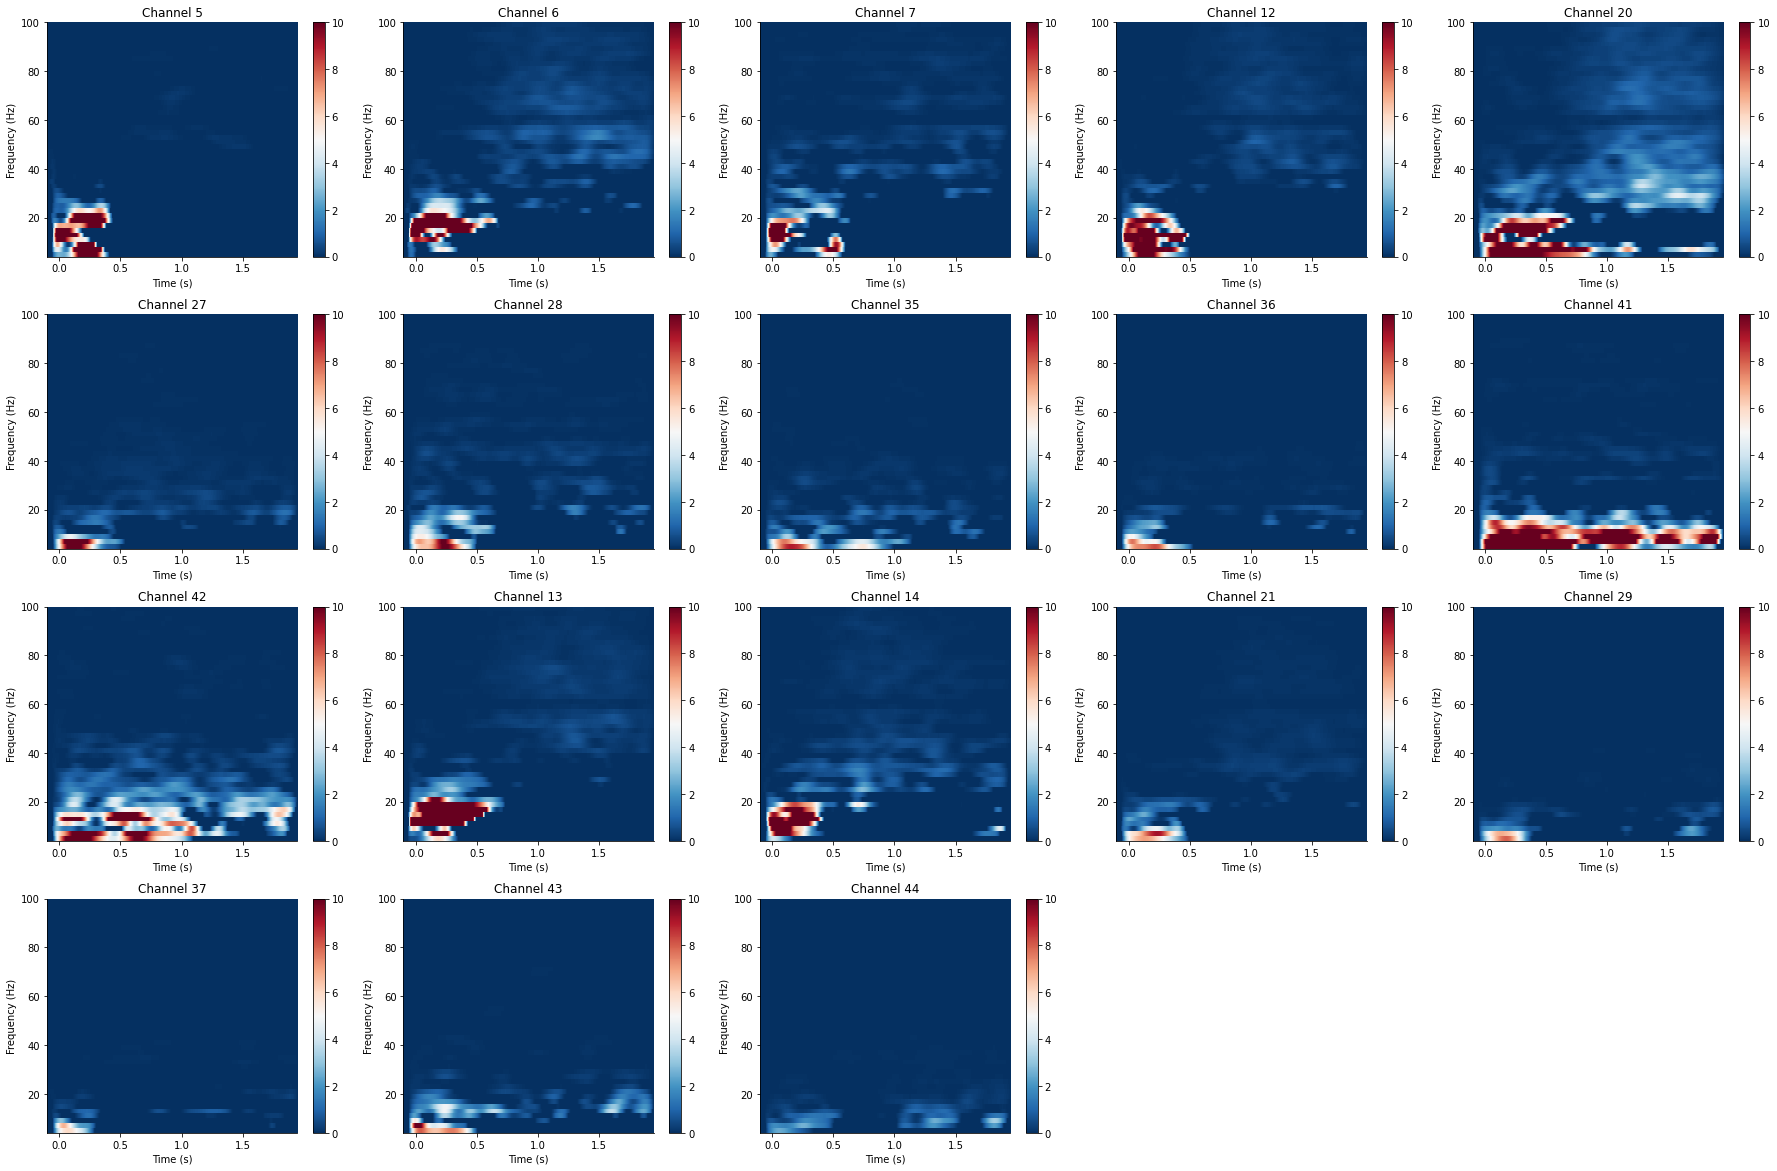

In [289]:
# Time-Frequency Decomposition Using Morlet Wavelet (Hand - Real Movement)

# ROI Channels
channels = electrode_roi[0]
n_channels = len(channels)

# TFA Parameters
freqs = np.arange(5., 100., 2.)
n_cycles = freqs/2.
vmin, vmax = 0., 10. 

# Decompose All Channels
power = tfr_morlet(hand_epochs_real[0], freqs=freqs, use_fft=True, n_cycles=n_cycles, return_itc=False, picks=channels)

# Plot Resulting Spectrogram of All Channels
print("Hand - Real Movement:")
plt.figure(figsize=(25, 20))
for index, channel in enumerate(channels):
  ax = plt.subplot(5, 5, index+1)
  power.plot([index], mode='mean', vmin=vmin, vmax=vmax, baseline=(-0.1, 0.), axes=ax, show=False, colorbar=True, verbose='WARNING')
  ax.set_title('Channel {}'.format(channel))
plt.show()

Hand - Imagery Movement:


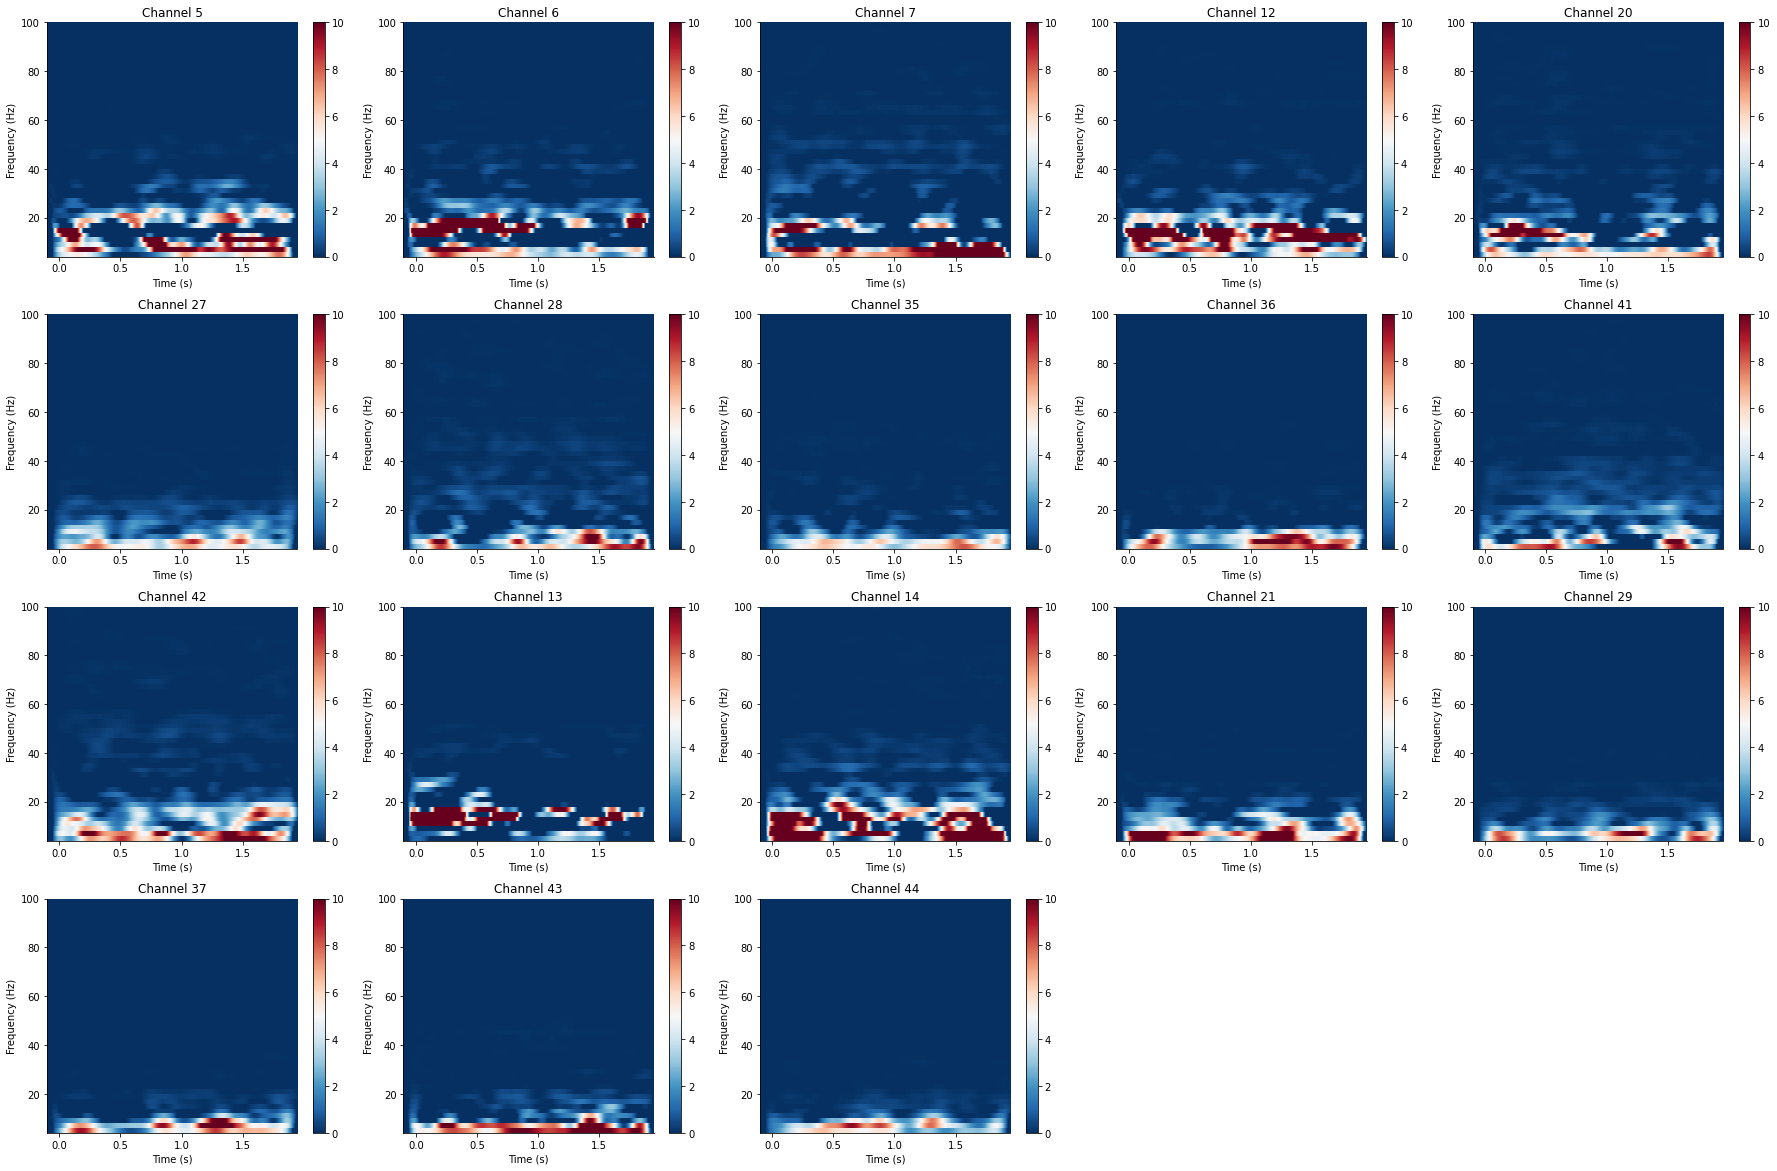

In [314]:
# Time-Frequency Decomposition Using Morlet Wavelet (Hand - Imagery Movement)

# ROI Channels
channels = electrode_roi[0]
n_channels = len(channels)

# TFA Parameters
freqs = np.arange(5., 100., 2.)
n_cycles = freqs/2.
vmin, vmax = 0., 10. 

# Decompose All Channels
power = tfr_morlet(hand_epochs_imagery[0], freqs=freqs, use_fft=True, n_cycles=n_cycles, return_itc=False, picks=channels)

# Plot Resulting Spectrogram of All Channels
print("Hand - Imagery Movement:")
plt.figure(figsize=(25, 20))
for index, channel in enumerate(channels):
  ax = plt.subplot(5, 5, index+1)
  power.plot([index], mode='mean', vmin=vmin, vmax=vmax, baseline=(-0.1, 0.), axes=ax, show=False, colorbar=True, verbose='WARNING')
  ax.set_title('Channel {}'.format(channel))
plt.show()

In [324]:
power.data.shape

(18, 48, 2048)